In [160]:
import os
import cv2
import json
import math
import torch
import torchvision
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from copy import deepcopy
from pprint import pprint
from skimage import io, transform
from scipy.io import loadmat, savemat
from torch.utils.data import Dataset, DataLoader

### Example Annotation

In [2]:
annotation_path = "/Users/shashanks./college/rrc/dataset/mpii/annot/train.json"
dataset_path = "/Users/shashanks./college/rrc/dataset/mpii/images"

with open(annotation_path, 'r') as f:
    annotation_json = json.load(f)

pprint(annotation_json[0])

{'center': [594.0, 257.0],
 'image': '015601864.jpg',
 'joints': [[620.0, 394.0],
            [616.0, 269.0],
            [573.0, 185.0],
            [647.0, 188.0],
            [661.0, 221.0],
            [656.0, 231.0],
            [610.0, 187.0],
            [647.0, 176.0],
            [637.0201, 189.8183],
            [695.9799, 108.1817],
            [606.0, 217.0],
            [553.0, 161.0],
            [601.0, 167.0],
            [692.0, 185.0],
            [693.0, 240.0],
            [688.0, 313.0]],
 'joints_vis': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'scale': 3.021046}


### MPII Flipped pairs

In [3]:
flip_pairs = [
    [0, 5], # Right and Left Ankle
    [1, 4], # Right and Left Knee
    [2, 3], # Right and Left Hip
    [10, 15], # Right and Left Wrist
    [11, 14], # Right and Left Elbow
    [12, 13] # Right and Left Shoulder 
]

### Keypoint Names

In [156]:
keypoints_names = {
    0 : "Right Ankle",
    1 : "Right Knee",
    2 : "Right Hip",
    3 : "Left Hip",
    4 : "Left Knee",
    5 : "Left Ankle",
    6 : "Pelvis",
    7 : "Thorax",
    8 : "Upper neck",
    9 : "Head top",
    10: "Right Wrist",
    11: "Right Elbow",
    12: "Right Shoulder",
    13: "Left Shoulder",
    14: "Left Elbow",
    15: "Left Wrist"
}

### Display keypoints image

In [4]:
def disp_keypoints_image(img, keypoints):    
    fig = plt.figure(figsize=(7, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    keypoints_num = list(range(len(keypoints)))
    ax1.imshow(img)
    ax1.scatter(keypoints[:, 0], keypoints[:, 1])
    
    for i, txt in enumerate(keypoints_num):
        ax1.annotate(txt, (keypoints[i, 0], keypoints[i, 1]), c='w')
    plt.show()

In [5]:
def disp_bbox_image(img, center, scale):
    x, y = int(center[0] - scale / 2.0), int(center[1] - scale / 2.0)
    w, h = int(scale), int(scale)

    fig = plt.figure(figsize=(5, 5))
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    plt.scatter([x], [y])

    # Add the patch to the Axes
    ax1.add_patch(rect)
    plt.show()

In [6]:
idx = 5432
img_path = deepcopy(os.path.join(dataset_path, annotation_json[idx]['image']))
center = deepcopy(annotation_json[idx]['center'])
scale = deepcopy(annotation_json[idx]['scale'])
joints = deepcopy(np.array(annotation_json[idx]['joints']))
visible_joints = deepcopy(np.array(annotation_json[idx]['joints_vis']))
img = cv2.imread(img_path)[:,:,::-1] #OpenCV uses BGR channels

# Adjust center/scale slightly to avoid cropping limbs
if center[0] != -1:
    center[1] = center[1] + 15 * scale
    scale = scale * 1.25

In [7]:
sample = {
    "image": img,
    "keypoints": joints,
    "visible_keypoints": visible_joints,
    "scale": scale,
    "center": center
}

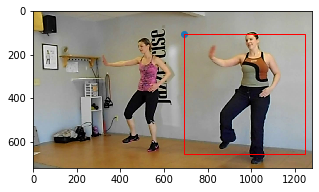

In [8]:
disp_bbox_image(sample["image"], sample["center"], sample["scale"] * 200.0)

### Horizontal Flip

In [9]:
class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        assert prob >= 0 and prob <= 1, "Invalid probability"
        self.prob = prob

    def __call__(self, sample):
        img = deepcopy(sample.get("image"))
        keypoints = deepcopy(sample.get("keypoints"))
        visible_keypoints = deepcopy(sample.get("visible_keypoints"))
        scale = deepcopy(sample.get("scale"))
        center = deepcopy(sample.get("center"))        
        img_shape = np.array(img.shape[:2])
        
        # Get the centerpoints, we flip rows and columns as we are dealing with matrices
        img_center = img_shape[::-1] / 2
        if np.random.rand() < self.prob:
            img =  img[:, ::-1, :] # Flip the image
            keypoints[:, 0] += 2 * (img_center[0] - keypoints[:, 0])
            center[0] += 2 * (img_center[0] - center[0])
            
            for pair in flip_pairs:
                idx_1, idx_2 = pair
                keypoints[idx_1, :], keypoints[idx_2, :] = keypoints[idx_2, :], keypoints[idx_1, :].copy()
                visible_keypoints[idx_1], visible_keypoints[idx_2] = visible_keypoints[idx_2], visible_keypoints[idx_1].copy()
        
            updated_sample = {
                "image": img,
                "keypoints": keypoints,
                "visible_keypoints": visible_keypoints, # Will remain same
                "scale": scale,
                "center": center
            }
            return updated_sample
        return deepcopy(sample)

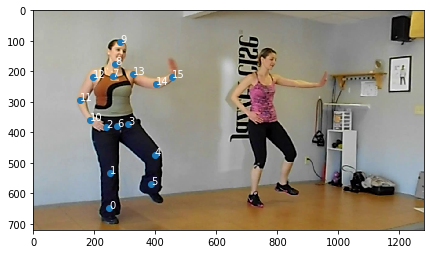

In [10]:
r = RandomHorizontalFlip()
updated_sample = r(sample)
disp_keypoints_image(updated_sample["image"], updated_sample["keypoints"])

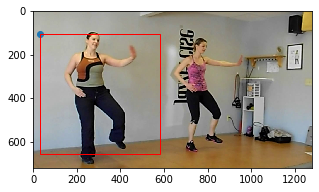

In [11]:
disp_bbox_image(updated_sample["image"], updated_sample["center"], updated_sample["scale"] * 200.0)

### Crop and Scale Transform

In [12]:
class CropAndScale(object):
    """Crops an image based on the defined bounding box
    If bounding box coordinates lies outside the image, then clips it and replaces
    the clipped portion with zeros. 
    
    Finally resizes the image to a square sized image given by the parameter size
    
    Parameters
    ----------
    scale: float
        Final size of the image
    """
    
    def __init__(self, size):
        self.size = size
    
    def __call__(self, sample):
        img = deepcopy(sample.get("image"))
        keypoints = deepcopy(sample.get("keypoints"))
        visible_keypoints = deepcopy(sample.get("visible_keypoints"))
        scale = deepcopy(sample.get("scale"))
        center = deepcopy(sample.get("center"))
        
        # Need to multiply scale by 200 in case of MPII dataset
        # See the Hourglass paper for more details
        scale = int(scale * 200.0)
        w, h = scale, scale
        orig_h, orig_w, _ = img.shape
        
        # Compute the upper left and bottom right bounding boxes of the person of interest
        upper_left = int(center[0] - scale / 2.0), int(center[1] - scale / 2.0)
        bottom_right = upper_left[0] + w, upper_left[1] + h
        
        # New image of size H x W x C, H & W are cropped sizes (Here H = W)
        new_shape = [bottom_right[1] - upper_left[1], bottom_right[0] - upper_left[0], img.shape[2]] 
        new_img = np.zeros(new_shape)
        
        # Range to fill new array
        # Look at this diagram () for more details: 
        new_x = max(0, -upper_left[0]), min(bottom_right[0], orig_w) - upper_left[0]
        new_y = max(0, -upper_left[1]), min(bottom_right[1], orig_h) - upper_left[1]
        
        # Range to sample from original image
        # Look at this diagram () for more details:
        old_x = max(0, upper_left[0]), min(orig_w, bottom_right[0])
        old_y = max(0, upper_left[1]), min(orig_h, bottom_right[1])
        
        # Update image array
        new_img[new_y[0]:new_y[1], new_x[0]:new_x[1]] = img[old_y[0]:old_y[1], old_x[0]:old_x[1]]
        new_img = cv2.resize(new_img, (self.size, self.size))
        new_img = new_img.astype(np.uint8)
        
        # Update keypoints location
        keypoints = keypoints - [upper_left[0], upper_left[1]]
        keypoints = keypoints * self.size / scale
        
        # Update center point
        new_center = np.array([new_img.shape[0] / 2, new_img.shape[1] / 2])
        
        # Update scale
        new_scale = max(new_img.shape[0], new_img.shape[1])
        
        updated_sample = {
            "image": new_img,
            "keypoints": keypoints,
            "visible_keypoints": visible_keypoints, # Will remain same
            "scale": new_scale,
            "center": new_center
        }
        return updated_sample

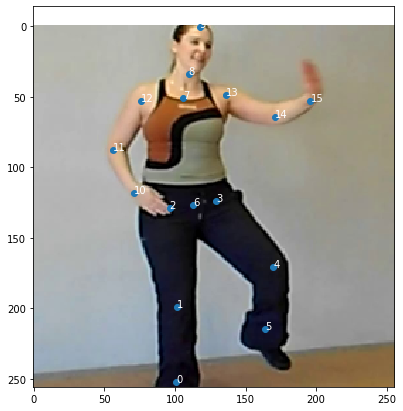

In [13]:
crop_scale_transform = CropAndScale(size=256)
updated_sample = crop_scale_transform(updated_sample)
disp_keypoints_image(updated_sample["image"], updated_sample["keypoints"])

### Affine Transformation

In [14]:
class AffineTransform(object):
    def __init__(self, input_res=256, output_res=64, rotation_prob=0.5):
        self.input_res = input_res
        self.output_res = output_res
        self.rotation_prob = rotation_prob
    
    def get_translation_matrix(self, pt):
        "Translate the points to the given point pt"
        T = np.float32([
            [1, 0, pt[0]], 
            [0, 1, pt[1]], 
            [0, 0, 1]
        ])
        return T
    
    def get_rotation_matrix(self, rot_angle):
        "Rotate the points with rot_angle around the center"
        rot_rad = - rot_angle * np.pi / 180
        sn, cs = np.sin(rot_rad), np.cos(rot_rad)
        T = np.float32([
            [cs, -sn, 0],
            [sn,  cs, 0],
            [0 ,   0, 1]
        ])        
        return T
    
    def get_scale_matrix(self, scale_x, scale_y):
        "Scale the points along x & y directions with scale_x & scale_y"
        T = np.float32([
            [scale_x, 0      , 0], 
            [0      , scale_y, 0], 
            [0      , 0      , 1]
        ])
        return T
    
    def get_affine_matrix(self, center, scale, res, rot_angle):
        # First translate all the image points to the center of the image
        # We want to scale the image from the center portion
        T1 = self.get_translation_matrix(-center)
        
        # Scale the image along x & y with values scale_x & scale_y 
        # Numpy arrays and image axes are flipped
        scale_x, scale_y = res[1] / scale, res[0] / scale
        T2 = self.get_scale_matrix(scale_x, scale_y)
        
        # Rotate the image around the center with angle rot_angle
        T3 = self.get_rotation_matrix(rot_angle)
        
        # Translate the image points to the new origin point
        # Numpy arrays and image axes are flipped
        T4 = self.get_translation_matrix([res[1] / 2, res[0] / 2])
        T_final = np.dot(T4, np.dot(T3, np.dot(T2, T1)))
        return T_final
    
    def get_random_range(self, xmin, xmax):
        return np.random.random() * (xmax - xmin) + xmin
    
    def get_keypoints(self, keypoints, T_keypoints):
        new_keypoints = np.c_[keypoints, np.ones(len(keypoints))]
        return np.dot(new_keypoints, T_keypoints.T).reshape(keypoints.shape)
    
    def update_visible_keypoints(self, res, keypoints, visible_keypoints):
        for i, point in enumerate(keypoints):
            # Axes of image and keypoints are interchanged
            x, y = np.round(point[0]), np.round(point[1])
            if x < 0 or x >= res[1] or y < 0 or y >= res[0]:
                visible_keypoints[i] = 0
        return visible_keypoints
    
    def __call__(self, sample):
        img = deepcopy(sample.get("image"))
        keypoints = deepcopy(sample.get("keypoints"))
        visible_keypoints = deepcopy(sample.get("visible_keypoints"))
        scale = deepcopy(sample.get("scale"))
        center = deepcopy(sample.get("center"))
        
        # Scale and rotate by a random value in given range
        scale = scale * self.get_random_range(xmin=0.75, xmax=1.25)
        rot_angle = 0
        if np.random.uniform() >= self.rotation_prob:
            rot_angle = self.get_random_range(xmin=-30, xmax=30)
        
        # Get affine transforms for image and keypoints respectively
        T_img = self.get_affine_matrix(center, scale, (self.input_res, self.input_res), rot_angle)[:2]
        T_keypoints = self.get_affine_matrix(center, scale, (self.output_res, self.output_res), rot_angle)[:2]
        
        new_img = cv2.warpAffine(img, T_img, (self.input_res, self.input_res))
        new_keypoints = self.get_keypoints(keypoints, T_keypoints)
        new_visible_keypoints = self.update_visible_keypoints((self.output_res, self.output_res), new_keypoints, visible_keypoints)
        
        updated_sample = {
            "image": deepcopy(new_img),
            "keypoints": deepcopy(new_keypoints),
            "visible_keypoints": deepcopy(new_visible_keypoints),
            "scale": deepcopy(scale),
            "center": deepcopy(center)
        }
        return updated_sample

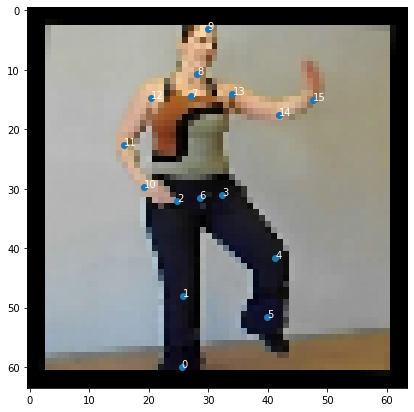

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
aff = AffineTransform(256, 64)
updated_sample1 = aff(updated_sample)
disp_keypoints_image(cv2.resize(updated_sample1["image"], (64, 64)), updated_sample1["keypoints"])
updated_sample1["visible_keypoints"]

### Generate Heatmaps

In [115]:
class GenerateHeatMaps(object):
    def __init__(self, output_res, keypoints, visible_keypoints, sigma=1):
        self.sigma = sigma
        self.keypoints = keypoints
        self.visible_keypoints = visible_keypoints
        self.num_keypoints = len(self.keypoints)
        self.size = output_res
        self.kernlen = 6 * self.sigma + 4
        self.heat_map = np.zeros((self.num_keypoints, self.size, self.size))
    
    def gkern(self, kernlen=10, nsig=1):
        """Returns a 2D Gaussian kernel.
        Implementation taken from this stackoverflow answer: https://stackoverflow.com/a/29731818
        """
        x = np.linspace(-nsig, nsig, kernlen+1)
        kern1d = np.diff(st.norm.cdf(x))
        kern2d = np.outer(kern1d, kern1d)
        return kern2d / kern2d[kernlen // 2, kernlen // 2]
    
    def get_heatmaps(self):
        for keypoint_num in range(self.keypoints.shape[0]):
            if self.visible_keypoints[keypoint_num]:
                x, y = int(np.round(self.keypoints[keypoint_num, 0])), int(np.round(self.keypoints[keypoint_num, 1]))
                _, orig_h, orig_w = self.heat_map.shape
                gauss_kern = self.gkern(self.kernlen, self.sigma)

                # Define bounds of the gaussian
                upper_left = x - 3 * self.sigma - 1, y - 3 * self.sigma - 1
                bottom_right = x + 3 * self.sigma + 2, y + 3 * self.sigma + 2

                # Range to fill new array
                # Look at this diagram () for more details:             
                new_x = max(0, -upper_left[0]), min(bottom_right[0], orig_w) - upper_left[0]
                new_y = max(0, -upper_left[1]), min(bottom_right[1], orig_h) - upper_left[1]

                # Range to sample from original heatmap
                # Look at this diagram () for more details:
                old_x = max(0, upper_left[0]), min(orig_w, bottom_right[0])
                old_y = max(0, upper_left[1]), min(orig_h, bottom_right[1])

                self.heat_map[keypoint_num, old_y[0]:old_y[1], old_x[0]:old_x[1]] = gauss_kern[new_y[0]:new_y[1], new_x[0]:new_x[1]]
        return self.heat_map

In [116]:
g = GenerateHeatMaps(64, deepcopy(updated_sample1["keypoints"]), deepcopy(updated_sample1["visible_keypoints"]))
hmaps = g.get_heatmaps()

In [134]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

In [157]:
def disp_heatmap(img, heat_maps):
    y, x = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    #Use base cmap to create transparent
    mycmap = transparent_cmap(plt.cm.Reds)
    
    #Plot image and overlay colormap
    fig, ax = plt.subplots(4, 4, figsize=(15, 15), sharey='row')
    heatmap_num = 0
    for row in range(4):
        for col in range(4):
            ax[row, col].set_title(keypoints_names[heatmap_num])
            ax[row, col].imshow(img)
            cb = ax[row, col].contourf(x, y, hmaps[heatmap_num], 15, cmap=mycmap)
            heatmap_num += 1

    plt.show()

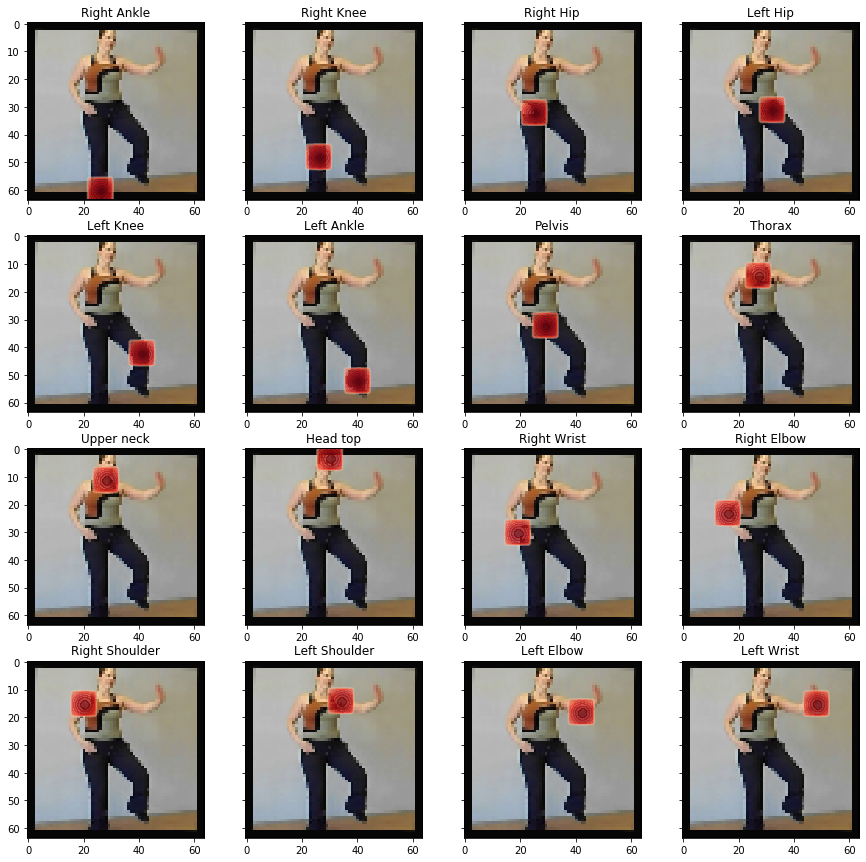

In [158]:
disp_heatmap(img1, hmaps)

### Evaluation

In [159]:
gt_mat_path = "/Users/shashanks./college/rrc/dataset/mpii/annot/gt_valid.mat"

In [165]:
gt_dict = loadmat(gt_mat_path)
pprint(gt_dict)

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr '
               b'02 14:41:19 2015',
 '__version__': '1.0',
 'dataset_joints': array([[array(['rank'], dtype='<U4'), array(['rkne'], dtype='<U4'),
        array(['rhip'], dtype='<U4'), array(['lhip'], dtype='<U4'),
        array(['lkne'], dtype='<U4'), array(['lank'], dtype='<U4'),
        array(['pelv'], dtype='<U4'), array(['thor'], dtype='<U4'),
        array(['neck'], dtype='<U4'), array(['head'], dtype='<U4'),
        array(['rwri'], dtype='<U4'), array(['relb'], dtype='<U4'),
        array(['rsho'], dtype='<U4'), array(['lsho'], dtype='<U4'),
        array(['lelb'], dtype='<U4'), array(['lwri'], dtype='<U4')]],
      dtype=object),
 'headboxes_src': array([[[ 914.0000113 ,  316.        ,  972.99999519, ...,
          928.00000495,  542.9999942 ,  400.00000204],
        [  78.99999859,  105.00000188,  179.00000205, ...,
          110.99999874,   88.99999557,  140.00000075]],

       [

In [171]:
dataset_joints = gt_dict['dataset_joints']
jnt_missing = gt_dict['jnt_missing']
pos_gt_src = gt_dict['pos_gt_src']
headboxes_src = gt_dict['headboxes_src']

In [181]:
head = np.where(dataset_joints == 'head')

In [182]:
head

(array([0]), array([9]))

In [183]:
dataset_joints

array([[array(['rank'], dtype='<U4'), array(['rkne'], dtype='<U4'),
        array(['rhip'], dtype='<U4'), array(['lhip'], dtype='<U4'),
        array(['lkne'], dtype='<U4'), array(['lank'], dtype='<U4'),
        array(['pelv'], dtype='<U4'), array(['thor'], dtype='<U4'),
        array(['neck'], dtype='<U4'), array(['head'], dtype='<U4'),
        array(['rwri'], dtype='<U4'), array(['relb'], dtype='<U4'),
        array(['rsho'], dtype='<U4'), array(['lsho'], dtype='<U4'),
        array(['lelb'], dtype='<U4'), array(['lwri'], dtype='<U4')]],
      dtype=object)

In [204]:
rhip = np.where(dataset_joints == 'rhip')[1][0]
rhip

2

In [201]:
test_annotation_path = "/Users/shashanks./college/rrc/dataset/mpii/annot/valid.json"

with open(test_annotation_path, 'r') as f:
    test_annotation_json = json.load(f)

pprint(test_annotation_json[0])

{'center': [966.0, 340.0],
 'image': '005808361.jpg',
 'joints': [[804.0, 711.0],
            [816.0, 510.0],
            [908.0, 438.0],
            [1040.0, 454.0],
            [906.0, 528.0],
            [883.0, 707.0],
            [974.0, 446.0],
            [985.0, 253.0],
            [982.7591, 235.9694],
            [962.2409, 80.0306],
            [869.0, 214.0],
            [798.0, 340.0],
            [902.0, 253.0],
            [1067.0, 253.0],
            [1167.0, 353.0],
            [1142.0, 478.0]],
 'joints_vis': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'scale': 4.718488}


In [207]:
pos_gt_src[0, :, 0]

array([804.0000103 , 710.99996642])

In [208]:
pos_gt_src.shape

(16, 2, 2958)

In [211]:
headboxes_src[:, :, 0]

array([[ 914.0000113 ,   78.99999859],
       [1031.00002187,  237.00000855]])

In [212]:
headboxes_src[1, :, 0] - headboxes_src[0, :, 0]

array([117.00001056, 158.00000996])

In [214]:
headboxes_src[1, :, 0]

array([1031.00002187,  237.00000855])

In [ ]:
headsizes = headboxes_src[1, :, :] - headboxes_src[0, :, :]